このノートブックは、以下のノートブックを元に日本語訳、一部章立ての再構成、加筆を行いました。
https://colab.research.google.com/drive/1Enc-pKlP4Q3cimEBfcQv0B_6hUvjVL3o

# CycleGAN深層生成モデルによる画像間変換

[Parag K. Mital](https://pkmital.com)  
[Creative Applications of Deep Learning](https://www.kadenze.com/programs/creative-applications-of-deep-learning-with-tensorflow)  
[Kadenze, Inc.](https://kadenze.com)  


このコンテンツは、 [Kadenze Academy](https://kadenze.com)プログラムの一部、[Creative Applications of Deep Learning](https://www.kadenze.com/programs/creative-applications-of-deep-learning-with-tensorflow)コース用に作成されたものです。このコンテンツは[APL 2.0 ライセンス](https://github.com/pkmital/CycleGAN/blob/master/LICENSE)で保護されます

In [ ]:
!git clone https://github.com/pkmital/CycleGAN.git

fatal: destination path 'CycleGAN' already exists and is not an empty directory.



# 前書き

このノートブックは、以下の論文を紹介します。


(-0.5, 1773.5, 1345.5, -0.5)

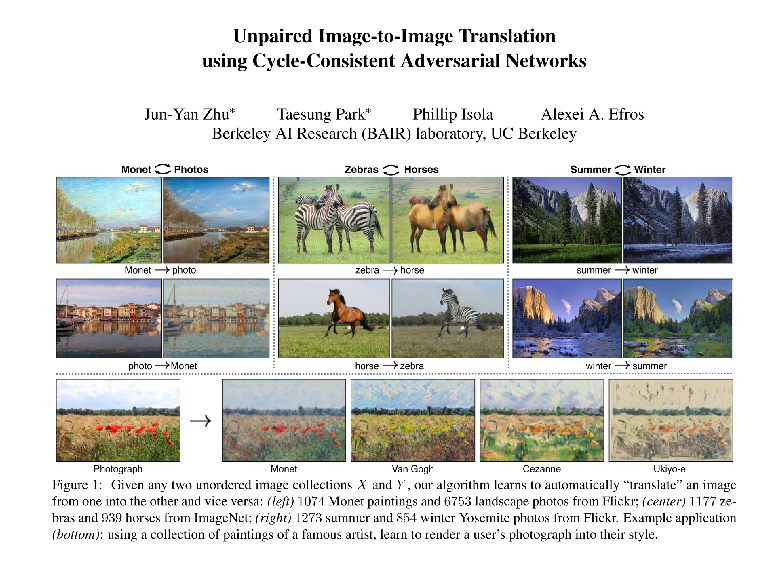

In [ ]:
%matplotlib inline
import matplotlib
plt = matplotlib.pyplot
plt.figure(figsize=(20,10))
plt.imshow(plt.imread('CycleGAN/imgs/cycle-gan-paper.png'))
plt.axis('off')


**画像から画像への変換** は、コンピュータグラフィックス、コンピュータビジョン、および画像とビデオを使った深層学習において、幅広い応用範囲があります。画像を入力し、それを変換した出力画像を得る、というのが基本です。これは、入出力が同じ画像であるオートエンコーダとは異なります。画像間の変換では、入力と出力それぞれが異なる画像のグループをとります。

例えば、以下の例が挙げられます。

- 入力画像は風景写真で、出力はその写真を芸術的にレタッチ
- 入力は馬の写真で、出力はシマウマの写真
- 街路や高速道路の輪郭を示す地図が入力で、それらが衛星画像のように見えるようなテクスチャを適用して出力する
- スケッチを猫の写真に変換するGoogle AI Experimentを再作成する
- あなたは人々の顔に笑顔を追加するアプリFaceAppを再作成する

これらはすべて画像から画像への変換の例です。 

このアイデアの最初期のデモに、Image Analogiesと呼ばれる2001年の論文があります。Aaron Hertzmannらは、類似の画像ペアを用いて、画像から画像への変換の基本的な考え方を示しました。例として道路地図の画像と、それに対応する衛星画像のようなアナロジー（類推）を与えると、他のどんな道路地図画像も与えても、モデルは新しい衛星画像を返してくれます。


(-0.5, 1885.5, 803.5, -0.5)

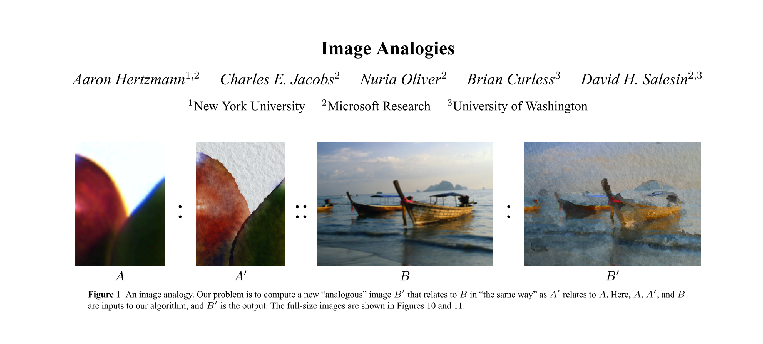

In [ ]:
plt.figure(figsize=(13,10))
plt.imshow(plt.imread('CycleGAN/imgs/image-analogies-paper.png'))
plt.axis('off')


どうしたら、同様のことができるニューラルネットワークを作れるでしょうか。オートエンコーダとGANにより、画像のとても優れた教師なしモデリングができるようになりました。例えば、出力とは異なる入力を持つオートエンコーダは、ある画像を別の画像に変換することを学習できます。また、白黒画像があり、それらをカラー画像に変換したい場合は、それぞれの画像のデータセットを作成してから、それぞれの種類の画像のペアをオートエンコーダに入力します。結果得られる損失関数は、出力にあるカラー画像を取り、白黒画像を入力とします。すると、ネットワークは画像をカラー化することを学習するでしょう。

しかし実際に試してみると、一般的に画像で使うには、オートエンコーダには大きな問題があると気付きます。オートエンコーダの損失関数は一般的にL2または二乗損失関数を使います。そのため、出力の画像がぼけていたり、そして単純なピクセルの集まりを超えて、画像の内容を理解できなかったりします。

GANは、独自の損失関数を別のネットワークの学習で得る、つまり、画像が真贋を判断する識別器を学習して得るため、同じ問題は起きません。では、画像を色付けすることを学ぶGANを作れるでしょうか。または、ストリートマップを衛星地図に変換するには？それとも画像から画像への変換に、他に応用できるでしょうか？このチュートリアルは画像間変換の最先端技術のひとつ、CycleGANを扱います。 



# CycleGAN

CycleGANは、Pix2Pixと呼ばれる以前の成果を基にしています。 
 
- **Pix2Pix**では、ペアでの変換が必要です。つまり学習データを与える時に、入力ごとに、出力がどのように見えるか、ひとつひとつのペアを対応づけて、正確に指定する必要があります。

- **CycleGAN**は、2つの*ペアになっていない*画像のコレクションを指定するだけで済みます。どの画像とどの画像が対応するかを指定する必要はありません。2つの画像のグループを与えたら、モデルがそれらの対応関係を見つけようと最善を尽くしてくれます。

CycleGANは、本当に素晴らしいネットワークで、構築はとても簡単です。コース1のセッション5（訳者注: [Creative Applications of Deep Learning](https://www.kadenze.com/programs/creative-applications-of-deep-learning-with-tensorflow)コース）で構築したDCGANやVAEGANと、共通するコンポーネントを多数使います。 


(-0.5, 879.5, 827.5, -0.5)

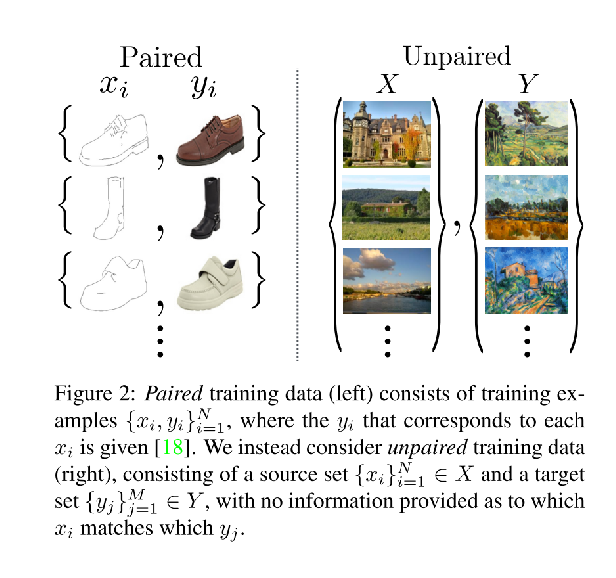

In [ ]:
plt.figure(figsize=(13,10))
plt.imshow(plt.imread('CycleGAN/imgs/cycle-gan-figure-2.png'))
plt.axis('off')


ある画像群を別の画像群に対応づけるという操作を、各画像群$ X $と$ Y $それぞれに対して作る必要があります。もう一段階の対応付けを行うことで、次のような2つの環状のマッピングを作ります。

1つ目のジェネレータが、最初の画像群$ X $を2番目の群$ Y $にマッピングし、出来た偽の$ Y $を$\hat{Y}$と表します。もうひとつのジェネレータは、画像群$ Y $と偽の$\hat{Y}$を、画像群$\hat{X}$にマッピングします。

言葉で表すと複雑ですが、これが$ X $と$ Y $の2つの画像群でどう働くか、以下でグラフィカルに見ることができます。 


(-0.5, 1793.5, 705.5, -0.5)

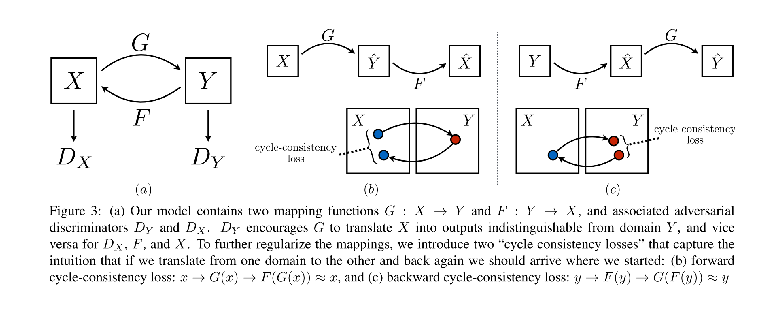

In [ ]:
plt.figure(figsize=(13,10))
plt.imshow(plt.imread('CycleGAN/imgs/cycle-gan-figure-3.png'))
plt.axis('off')


# クイズ： 

>  CycleGANネットワークにはいくつのgeneratorがありますか？

> CycleGANネットワークにはいくつのdiscriminatorがありますか？ 



# エンコーダ

このネットワークは基本的に2つのGenerator（上の画像の$ G $と$ F $ ）と2つのDiscriminator（上の画像の$D_X$と$D_Y$ ）を使った、2つのオートエンコーダを学習させます。既にGANをご存知なら、アイデアは簡単に理解できるでしょう。難しい部分のほとんどは、実装の詳細です。 

Generatorは、通常のGANと少し異なります。例えば100の値からなるランダムな特徴ベクトルを入力とするのではなく、画像を入力にとります。次にオートエンコーダと似たものを作りますが、これも構造が少し異なります。エンコーダ、トランスフォーマ、デコーダの3つの主要コンポーネントがあります。 

エンコーダはストライド2のいくつかの畳み込み層から成り、各層で画像をダウンサンプリングします。論文ではそれを3層の畳み込み層を使い、最初の層にパディングを入れます。 

それをどうコードで表現するか見てみましょう。まずいくつかimportがあります。TensorFlowと、 Kerasと同様にレイヤの記述を非常に簡単にするcontribパッケージが含まれます。 CycleGANの作者が行ったように、レイヤの正規化にはInstance Normalization（ [http://arxiv.org/abs/1607.08022](http://arxiv.org/abs/1607.08022) ）、そして活性化関数にLeaky ReLUを使います。 CycleGANの実装とすべてのユーティリティ関数を`cycle_gan.py`モジュールにまとめました。これは、 `cadl`リポジトリにもあります: https://github.com/pkmital/pycadl （簡単にpipでインストールできます: `pip install cadl` ）


In [ ]:
!pip install cadl
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as tfl
from cadl.cycle_gan import lrelu, instance_norm

/usr/local/lib/python3.6/dist-packages/cadl/cycle_gan.py:21: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.6/dist-packages/zmq/


それではCycleGANアーキテクチャに従って、エンコーダ用の関数を書いてみましょう。このような順番で、各層をつなぎます。

- パディング
- ストライドが1の畳み込み層(7 x 7の畳み込み)
- ストライドが2の畳み込み層(3 x 3の畳み込み)
- ストライドが2の畳み込み層(3 x 3の畳み込み)

そして、正規分布を使って、重みを標準偏差0.02に初期化します。活性化関数には、leakageが0.2のLeaky ReLUを使います。各層のフィルター数は、32から始めて、64、128と指数関数的に増やします。最後に、インスタンス正規化と呼ばれるバッチ正規化と似たもの、またTensorFlow layerモジュールを使い、ひとつの関数でまとめて全体の畳み込み演算をできるようにしました： 


In [ ]:
def encoder(x, n_filters=32, k_size=3, normalizer_fn=instance_norm,
        activation_fn=lrelu, scope=None, reuse=None):
    with tf.variable_scope(scope or 'encoder', reuse=reuse):
        h = tf.pad(x, [[0, 0], [k_size, k_size], [k_size, k_size], [0, 0]],
                "REFLECT")
        h = tfl.conv2d(
                inputs=h,
                num_outputs=n_filters,
                kernel_size=7,
                stride=1,
                padding='VALID',
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                normalizer_fn=normalizer_fn,
                activation_fn=activation_fn,
                scope='1',
                reuse=reuse)
        h = tfl.conv2d(
                inputs=h,
                num_outputs=n_filters * 2,
                kernel_size=k_size,
                stride=2,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                normalizer_fn=normalizer_fn,
                activation_fn=activation_fn,
                scope='2',
                reuse=reuse)
        h = tfl.conv2d(
                inputs=h,
                num_outputs=n_filters * 4,
                kernel_size=k_size,
                stride=2,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                normalizer_fn=normalizer_fn,
                activation_fn=activation_fn,
                scope='3',
                reuse=reuse)
    return h

この後すぐに出てきますが、これらの変数は何回か再利用するため、範囲と再利用を明示的に記述しました。 

# 残差ブロックとTransformer

Generatorの次の部分はトランスフォーマ（Transformer）です。これらは6か9個の残差ブロックから成ります。残差ブロックは、最近のアーキテクチャで頻出の強力なモジュールです。単なる畳み込み層ではなく、畳み込み層をの出力と、元々のその層への入力を合計し、出力とします。そのため、入力の、ある種の残差（residual, 残りものの意）関数を学習するといえます。残差ブロックは、ベースの活性化を次にバイパスして伝えつつ、そこへの単純な加算を学習します。これにより、元の活性化が出力までの（畳み込み層を介さない）バイパスを持つことになります。また同様に、一定以上多層のネットワークで起こりがちな勾配消失・爆発の発生を抑え、誤差逆伝播を安定させます。残差ネットワークの詳細は、勾配消失・爆発の問題を抱えず、何千層ものモデルを作る方法を示した元論文を読んでみてください。

それでは、残差ブロックをコーディングしましょう。すべての畳み込みはシングルストライド、128チャンネルです。

各ブロックは、以下から成っています。

- パディング
- Leaky ReLUとインスタンス正規化を用いた3x3の畳み込み
- パディング
- 非線形の活性化関数を持たず、インスタンス正規化を用いた別の畳み込み
- 開始時の活性化との加算



In [ ]:
def residual_block(x, n_channels=128, normalizer_fn=instance_norm,
        activation_fn=lrelu, kernel_size=3, scope=None, reuse=None):
    with tf.variable_scope(scope or 'residual', reuse=reuse):
        h = tf.pad(x, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
        h = tfl.conv2d(
                inputs=h,
                num_outputs=n_channels,
                kernel_size=kernel_size,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                normalizer_fn=normalizer_fn,
                padding='VALID',
                activation_fn=activation_fn,
                scope='1',
                reuse=reuse)
        h = tf.pad(x, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
        h = tfl.conv2d(
                inputs=h,
                num_outputs=n_channels,
                kernel_size=kernel_size,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                normalizer_fn=normalizer_fn,
                padding='VALID',
                activation_fn=None,
                scope='2',
                reuse=reuse)
        h = tf.add(x, h)
    return h


これで、9個または6個の残差ブロックを使って、Transformerを作成します。


In [ ]:
def transform(x, img_size=256, reuse=None):
    h = x
    if img_size >= 256:
        n_blocks = 9
    else:
        n_blocks = 6
    for block_i in range(n_blocks):
        with tf.variable_scope('block_{}'.format(block_i), reuse=reuse):
            h = residual_block(h, reuse=reuse)
    return h


# デコーダ

素晴らしいですね! Generatorをコードで書き表すにあたって、最後の部分はデコーダです。基本、デコーダは、エンコーダの正反対の処理をします。

- ストライドが2の逆畳み込み層(3 x 3の畳み込み)
- ストライドが2の逆畳み込み層(3 x 3の畳み込み)
- パディング
- ストライドが1の逆畳み込み層(7 x 7の畳み込み)

最終層の前には、より大きい7x7カーネルでの境界アーティファクト（画像の隅における意図しないノイズ、歪み）を避けるため、パディングを入れます。活性化関数はtanhで、各ピクセルを表す値は-1から1の範囲になります。開始点となる0は、白と黒の中間であるグレーとなるため、画像において理想的な正規化といえるでしょう。データをネットワークに入力する時は、この点に留意し、同じ範囲に各ピクセルの数値がおさまっているか確認します。


In [ ]:
def decoder(x, n_filters=32, k_size=3, normalizer_fn=instance_norm,
        activation_fn=lrelu, scope=None, reuse=None):
    with tf.variable_scope(scope or 'decoder', reuse=reuse):
        h = tfl.conv2d_transpose(
                inputs=x,
                num_outputs=n_filters * 2,
                kernel_size=k_size,
                stride=2,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                normalizer_fn=normalizer_fn,
                activation_fn=activation_fn,
                scope='1',
                reuse=reuse)
        h = tfl.conv2d_transpose(
                inputs=h,
                num_outputs=n_filters,
                kernel_size=k_size,
                stride=2,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                normalizer_fn=normalizer_fn,
                activation_fn=activation_fn,
                scope='2',
                reuse=reuse)
        h = tf.pad(h, [[0, 0], [k_size, k_size], [k_size, k_size], [0, 0]],
                "REFLECT")
        h = tfl.conv2d(
                inputs=h,
                num_outputs=3,
                kernel_size=7,
                stride=1,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                padding='VALID',
                normalizer_fn=normalizer_fn,
                activation_fn=tf.nn.tanh,
                scope='3',
                reuse=reuse)
    return h


これらをまとめて、Generatorはエンコーダ, トランスフォーマ, デコーダの組み合わせから成ります:


In [ ]:
def generator(x, scope=None, reuse=None):
    img_size = x.get_shape().as_list()[1]
    with tf.variable_scope(scope or 'generator', reuse=reuse):
        h = encoder(x, reuse=reuse)
        h = transform(h, img_size, reuse=reuse)
        h = decoder(h, reuse=reuse)
    return h


#  PatchGAN、受容野のサイズ、およびDiscriminator

もうひとつの主要コンポーネントはDiscriminatorです。このネットワークは通常、入力に画像を受け取り、単一の値を出力します。真の画像と判定したら1を、偽の画像は0を出力します。Generatorでは、反対のことを真にします。Discriminatorの出力は、0から1の範囲が期待されるので、活性化関数にシグモイド関数を使います。ネットワークは、入力として256 x 256ピクセルの画像を受け取り、すでに使用しているものとは異なった、一連の5つの畳み込みレイヤーを使用します。最初の3つのレイヤーはストライド2になり、最後の2つはストライド1になります。最後のレイヤーが1つの出力になるまで、出力数を指数関数的に増やします。 

ここで作るDiscriminatorは、典型的なGANとは異なり、Pix2PixとCycleGANの著者がPatchGAN discriminatorと名付けたものです。このネットワークは、画像を1つの値に変換するのではなく、256 x 256の画像を、出力に1チャンネルをもつ空間マップへ変換します。結果得られるマップは、個別のDiscriminatorを効果的に保持していて、最終結果は、それらの出力を平均して得られます。著者らは、いくつかのストライドとレイヤのサイズの組合せで最終層の受容野サイズを効果的に変えることを示し、また、この5層の組合せが最もパフォーマンスが良く、70という受容野サイズを持つことを示しました。

70という受容野サイズがどのようにして決められたか、もう少し詳しく見てみましょう。 


(-0.5, 2145.5, 1511.5, -0.5)

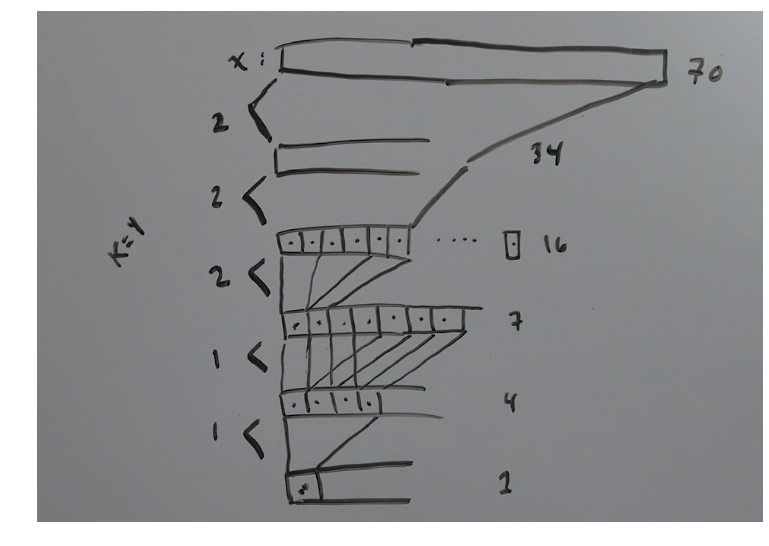

In [ ]:
plt.figure(figsize=(13,10))
plt.imshow(plt.imread('CycleGAN/imgs/receptive-field-sizes.png'))
plt.axis('off')


上の画像では、入力層が上に、最終層が下です。最終層から上に遡ると、1つのノードが前の層のノード数の増加にどう寄与するかわかります。最終層の一つのノードに対応する各層の受容野は右端に書かれています： [1, 4, 7, 16, 34, 70]

Discriminatorのコードは次のようになります。 


In [ ]:
def discriminator(x, n_filters=64, k_size=4, activation_fn=lrelu,
        normalizer_fn=instance_norm, scope=None, reuse=None):
    with tf.variable_scope(scope or 'discriminator', reuse=reuse):
        h = tfl.conv2d(
                inputs=x,
                num_outputs=n_filters,
                kernel_size=k_size,
                stride=2,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                activation_fn=activation_fn,
                normalizer_fn=None,
                scope='1',
                reuse=reuse)
        h = tfl.conv2d(
                inputs=h,
                num_outputs=n_filters * 2,
                kernel_size=k_size,
                stride=2,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                activation_fn=activation_fn,
                normalizer_fn=normalizer_fn,
                scope='2',
                reuse=reuse)
        h = tfl.conv2d(
                inputs=h,
                num_outputs=n_filters * 4,
                kernel_size=k_size,
                stride=2,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                activation_fn=activation_fn,
                normalizer_fn=normalizer_fn,
                scope='3',
                reuse=reuse)
        h = tfl.conv2d(
                inputs=h,
                num_outputs=n_filters * 8,
                kernel_size=k_size,
                stride=1,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                activation_fn=activation_fn,
                normalizer_fn=normalizer_fn,
                scope='4',
                reuse=reuse)
        h = tfl.conv2d(
                inputs=h,
                num_outputs=1,
                kernel_size=k_size,
                stride=1,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                activation_fn=tf.nn.sigmoid,
                scope='5',
                reuse=reuse)
        return h


# コンポーネント間をつなぐ

これで、CycleGANを作るために必要な主要コンポーネントが出揃いました。あとはいくつかのプレースホルダーを使ってそれらを接続、損失関数を作り、最後に学習方法を構築するだけです。プレースホルダーから始めましょう。 

 `X`と`Y`と呼ぶ2つの画像群それぞれのプレースホルダーから始めます。 


In [ ]:
img_size = 256
X_real = tf.placeholder(name='X', shape=[1, img_size, img_size, 3], dtype=tf.float32)
Y_real = tf.placeholder(name='Y', shape=[1, img_size, img_size, 3], dtype=tf.float32)


これらの「真」の入力から生成した「偽」の出力を得るため、対応するGeneratorに渡します。各方向1つずつGeneratorを用意します。

- 1つは画像群Xのスタイルを画像群Yのスタイルに変換します
- もう1つはその逆の変換をします


In [ ]:
X_fake = generator(Y_real, scope='G_yx')
Y_fake = generator(X_real, scope='G_xy')

Because this is a CycleGAN, we'll enforce an additional constraint on the generated output to match the original image quality with an L1-Loss.  This will effectively test both generators by generating from X to Y and then back to X again. Similarly, for Y, we'll generate to X, and again to Y.  To get these images, we simple reuse the existing generators and create the cycle images:


これはCycleGANなので、元の画質とL1-Lossを一致させるため、生成した出力に追加の制約をかけます。これはXからYへ、そして再びXへと生成することによって両方のGeneratorを効果的にテストします。同様に、Yの場合はXを生成し、さらにまたYを生成します。これらの画像を取得するには、既存2つのGeneratorを再利用し、環状に画像の生成をつなげます。 


In [ ]:
X_cycle = generator(Y_fake, scope='G_yx', reuse=True)
Y_cycle = generator(X_fake, scope='G_xy', reuse=True)


Discriminatorは、そのように`real` `fake`それぞれの画像に作用します。 


In [ ]:
D_X_real = discriminator(X_real, scope='D_X')
D_Y_real = discriminator(Y_real, scope='D_Y')
D_X_fake = discriminator(X_fake, scope='D_X', reuse=True)
D_Y_fake = discriminator(Y_fake, scope='D_Y', reuse=True)


Generatorの損失を計算するために、 `cycle`と`real`画像との間のL1距離を計算し、GeneratorがDiscriminatorをどの程度「欺く」かをテストします。 


In [ ]:
l1 = 10.0
loss_cycle = tf.reduce_mean(l1 * tf.abs(X_real - X_cycle)) + \
             tf.reduce_mean(l1 * tf.abs(Y_real - Y_cycle))
loss_G_xy = tf.reduce_mean(tf.square(D_Y_fake - 1.0)) + loss_cycle
loss_G_yx = tf.reduce_mean(tf.square(D_X_fake - 1.0)) + loss_cycle


筆者らは、L1サイクル損失に、一定の重み付け（ここでは10.0）を行うよう提案しています。 

最後に、Discriminatorの損失を計算します。現世代の偽の画像を使うGeneratorと違って、生成済み画像の履歴バッファを使って、このバッファから、画像をランダムに取り出して使います。 GANの先行研究がこうしたバッファ利用の有効性を示しており、CycleGANの著者も使用を提案しています。私たちは（TensorFlowグラフが保持されるGPU側との対比として）CPU側でこの履歴バッファを取り扱い、履歴画像をTensorFlowグラフ側に送るためのプレースホルダーを作っておきます： 


In [ ]:
X_fake_sample = tf.placeholder(name='X_fake_sample',
        shape=[None, img_size, img_size, 3], dtype=tf.float32)
Y_fake_sample = tf.placeholder(name='Y_fake_sample',
        shape=[None, img_size, img_size, 3], dtype=tf.float32)


そして、これらの画像を評価するようにDiscriminatorに依頼します。 


In [ ]:
D_X_fake_sample = discriminator(X_fake_sample, scope='D_X', reuse=True)
D_Y_fake_sample = discriminator(Y_fake_sample, scope='D_Y', reuse=True)


それから、Discriminatorの損失を計算できます。オリジナルGANの実装とは異なり、バイナリクロスエントロピー誤差ではなく、二乗誤差を使います。この方がエラーに強いためです。


In [ ]:
loss_D_Y = (tf.reduce_mean(tf.square(D_Y_real - 1.0)) + \
            tf.reduce_mean(tf.square(D_Y_fake_sample))) / 2.0
loss_D_X = (tf.reduce_mean(tf.square(D_X_real - 1.0)) + \
            tf.reduce_mean(tf.square(D_X_fake_sample))) / 2.0


# オプティマイザ

では、そのようなモデルのためにオプティマイザを構築する方法を見てみましょう。今行ったことはすべて、 `cycle_gan`という便利なモジュールにまとめました。ネットワーク全体を次のようにして作成できます。 


In [ ]:
tf.reset_default_graph()
from cadl.cycle_gan import cycle_gan
net = cycle_gan(img_size=img_size)


これにより、ネットワーク全体が辞書型の変数に戻されます。 


In [ ]:
list(net.items())

[('G_vars',
  [<tf.Variable 'G_xy/encoder/1/Conv/weights:0' shape=(7, 7, 3, 32) dtype=float32_ref>,
   <tf.Variable 'G_xy/encoder/1/instance_norm/scale:0' shape=(32,) dtype=float32_ref>,
   <tf.Variable 'G_xy/encoder/1/instance_norm/offset:0' shape=(32,) dtype=float32_ref>,
   <tf.Variable 'G_xy/encoder/2/Conv/weights:0' shape=(3, 3, 32, 64) dtype=float32_ref>,
   <tf.Variable 'G_xy/encoder/2/instance_norm/scale:0' shape=(64,) dtype=float32_ref>,
   <tf.Variable 'G_xy/encoder/2/instance_norm/offset:0' shape=(64,) dtype=float32_ref>,
   <tf.Variable 'G_xy/encoder/3/Conv/weights:0' shape=(3, 3, 64, 128) dtype=float32_ref>,
   <tf.Variable 'G_xy/encoder/3/instance_norm/scale:0' shape=(128,) dtype=float32_ref>,
   <tf.Variable 'G_xy/encoder/3/instance_norm/offset:0' shape=(128,) dtype=float32_ref>,
   <tf.Variable 'G_xy/block_0/residual/1/Conv/weights:0' shape=(3, 3, 128, 128) dtype=float32_ref>,
   <tf.Variable 'G_xy/block_0/residual/1/instance_norm/scale:0' shape=(128,) dtype=float32_ref


オリジナルのGAN実装と同様、ネットワークの特定部分のみ更新できる個別オプティマイザを作ります。オリジナルのGANは、GeneratorとDiscriminator、それぞれ用に2つのオプティマイザがありました。DiscriminatorはGeneratorからの入力に依存しますが、Discriminatorの学習を進める時は、Discriminatorに属する変数のみ最適化します。そうしないと、両方のネットワークの最適化を同時に進めてしまうと、Generatorを悪化させてしまうからです。ここでも同様に、3つのネットワークがあるので、3つの個別オプティマイザを作ります。 `G_xy`と`G_yx` 変数はGeneratorとして最適化されます。そして、 `D_X`と`D_Y`は2つの異なるDiscriminatorを更新します。 

まず変数を取得しましょう。 


In [ ]:
training_vars = tf.trainable_variables()
D_X_vars = [v for v in training_vars if v.name.startswith('D_X')]
D_Y_vars = [v for v in training_vars if v.name.startswith('D_Y')]
G_xy_vars = [v for v in training_vars if v.name.startswith('G_xy')]
G_yx_vars = [v for v in training_vars if v.name.startswith('G_yx')]
G_vars = G_xy_vars + G_yx_vars


そしてオプティマイザを作ります。


In [ ]:
learning_rate = 0.001
D_X = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(
        net['loss_D_X'], var_list=D_X_vars)
D_Y = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(
        net['loss_D_Y'], var_list=D_Y_vars)
G = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(
        net['loss_G'], var_list=G_vars)


両方のGeneratorを1つのリスト変数に連結したことに注意してください。 


In [ ]:
print(G)

name: "Adam_2"
op: "NoOp"
input: "^Adam_2/update_G_xy/encoder/1/Conv/weights/ApplyAdam"
input: "^Adam_2/update_G_xy/encoder/1/instance_norm/scale/ApplyAdam"
input: "^Adam_2/update_G_xy/encoder/1/instance_norm/offset/ApplyAdam"
input: "^Adam_2/update_G_xy/encoder/2/Conv/weights/ApplyAdam"
input: "^Adam_2/update_G_xy/encoder/2/instance_norm/scale/ApplyAdam"
input: "^Adam_2/update_G_xy/encoder/2/instance_norm/offset/ApplyAdam"
input: "^Adam_2/update_G_xy/encoder/3/Conv/weights/ApplyAdam"
input: "^Adam_2/update_G_xy/encoder/3/instance_norm/scale/ApplyAdam"
input: "^Adam_2/update_G_xy/encoder/3/instance_norm/offset/ApplyAdam"
input: "^Adam_2/update_G_xy/block_0/residual/1/Conv/weights/ApplyAdam"
input: "^Adam_2/update_G_xy/block_0/residual/1/instance_norm/scale/ApplyAdam"
input: "^Adam_2/update_G_xy/block_0/residual/1/instance_norm/offset/ApplyAdam"
input: "^Adam_2/update_G_xy/block_0/residual/2/Conv/weights/ApplyAdam"
input: "^Adam_2/update_G_xy/block_0/residual/2/instance_norm/scale/Apply


Discriminator学習の一環として、真の画像と生成された偽画像の識別をテストします。Discriminatorは、最新50個あまりの生成画像から、ランダムに画像を取り出します。これにより、学習が安定するとされています（Shrivastava, A., Pfister, T., Tuzel, O., Susskind, J., Wang, W., & Webb, R. (2016)  Learning from Simulated and Unsupervised Images through Adversarial Training [http://arxiv.org/abs/1612.07828](http://arxiv.org/abs/1612.07828) ）。詳細はセクション2.3を参照してください。ここでのアイデアは、Discriminatorが、以前の生成画像も偽物と識別できるはずだということです。Generatorが、Discriminatorが忘れたことを再度学習するだけのこともあります。これにより学習が安定化するとされています。 

このキャッシュを作るため、そのサイズ `capacity`を50などと決め、まず初期化として全ピクセルを0とした画像のリストを作っておきます。


In [ ]:
# How many fake generations to keep around
capacity = 50

# Storage for fake generations
fake_Xs = capacity * [np.zeros((1, img_size, img_size, 3), dtype=np.float32)]
fake_Ys = capacity * [np.zeros((1, img_size, img_size, 3), dtype=np.float32)]


# バッチジェネレータ

やっと、学習の準備が整いました。あと必要なのはデータセットだけです！一番大事なところですね。

CycleGANネットワークにデータを取り込めるように、2種類のバッチジェネレータを作りました。

- ひとつは、XとYの画像コレクションを配列として取ります。
- もう1つはXとYの単一の画像を取り、それをランダムにトリミングします。

Hieronymous BoschのGarden of Earthly Delightsなど、とても大きな画像でも、このネットワークを使うことができました。最初のコレクションはスケッチレンダリングで、2番目のコレクションは高解像度画像でした。 

In [ ]:
from cadl.cycle_gan import batch_generator_dataset, batch_generator_random_crop


データセットジェネレータを使うには、2つの配列の画像を `N` x `H` x `W` x 3 の形で食わせます。 


In [ ]:
# Load your data into imgs1 and imgs2 here!
# I've loaded in random noise as an example, but you'll want to use
# plt.imread or skimage to load in images into a list of images
ds_X, ds_Y = np.random.rand(10, img_size, img_size, 3), \
             np.random.rand(10, img_size, img_size, 3)


これで、 `batch_generator_dataset`関数を使い、CycleGANネットワークにバッチを取り込むことができます。 


In [ ]:
X_i, Y_i = next(batch_generator_dataset(ds_X, ds_Y))
X_i.shape, Y_i.shape

((1, 256, 256, 3), (1, 256, 256, 3))


あるいは `batch_generator_random_crop` 関数を使って、大きい画像をランダムに切り出してネットワークに入力することもできます。何が切り出され、どうリサイズされるかは、 `min_size` と `max_size` パラメータで設定します。 


In [ ]:
ds_X, ds_Y = np.random.rand(1024, 1024, 3), np.random.rand(1024, 1024, 3)
X_i, Y_i = next(batch_generator_random_crop(
        ds_X, ds_Y, min_size=img_size, max_size=512))
X_i.shape, Y_i.shape

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


((1, 256, 256, 3), (1, 256, 256, 3))


# 学習

 CADL `cycle_gan`モジュールには学習用の関数があるので、そのまま使えます。詳細が知りたければ、以下のコードにコメントをつけましたのでご覧ください。 


In [ ]:
idx = 0
it_i = 0
n_epochs = 10
ckpt_path = './'

In [ ]:
# Train
with tf.Session() as sess:
    # Build an init op for our variables
    init_op = tf.group(tf.global_variables_initializer(),
                       tf.local_variables_initializer())
    sess.run(init_op)
    
    # We'll also save our model so we can load it up again
    saver = tf.train.Saver()
    writer = tf.summary.FileWriter(ckpt_path)
    
    for epoch_i in range(n_epochs):
        # You'll want to use the approriate batch generator here!
        for X, Y in batch_generator_random_crop(ds_X, ds_Y):

            # First generate in both directions
            X_fake, Y_fake = sess.run(
                [net['X_fake'], net['Y_fake']],
                feed_dict={net['X_real']: X,
                           net['Y_real']: Y})

            # Now sample from history
            if it_i < capacity:
                # Not enough samples yet, fill up history buffer
                fake_Xs[idx] = X_fake
                fake_Ys[idx] = Y_fake
                idx = (idx + 1) % capacity
            elif np.random.random() > 0.5:
                # Swap out a random idx from history
                rand_idx = np.random.randint(0, capacity)
                fake_Xs[rand_idx], X_fake = X_fake, fake_Xs[rand_idx]
                fake_Ys[rand_idx], Y_fake = Y_fake, fake_Ys[rand_idx]
            else:
                # Use current generation
                pass

            # Optimize G Networks
            loss_G = sess.run(
                [net['loss_G'], G],
                feed_dict={
                    net['X_real']: X,
                    net['Y_real']: Y,
                    net['Y_fake_sample']: Y_fake,
                    net['X_fake_sample']: X_fake
                })[0]

            # Optimize D_Y
            loss_D_Y = sess.run(
                [net['loss_D_Y'], D_Y],
                feed_dict={
                    net['X_real']: X,
                    net['Y_real']: Y,
                    net['Y_fake_sample']: Y_fake
                })[0]

            # Optimize D_X
            loss_D_X = sess.run(
                [net['loss_D_X'], D_X],
                feed_dict={
                    net['X_real']: X,
                    net['Y_real']: Y,
                    net['X_fake_sample']: X_fake
                })[0]

            print(it_i, 'G:', loss_G, 'D_X:', loss_D_X, 'D_Y:', loss_D_Y)

            # Update summaries
            if it_i % 100 == 0:
                summary = sess.run(
                    net['summaries'],
                    feed_dict={
                        net['X_real']: X,
                        net['Y_real']: Y,
                        net['X_fake_sample']: X_fake,
                        net['Y_fake_sample']: Y_fake
                    })
                writer.add_summary(summary, it_i)
            it_i += 1

        # Save
        if epoch_i % 50 == 0:
            saver.save(
                sess,
                os.path.join(ckpt_path, 'model.ckpt'),
                global_step=epoch_i)
            
        # Show generative images:        
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))
        axs[0][0].set_title('X Real')
        axs[0][0].imshow(np.clip(X[0], 0.0, 1.0))
        axs[0][1].set_title('X Fake')
        axs[0][1].imshow(np.clip(X_fake[0], 0.0, 1.0))
        axs[1][0].set_title('Y')
        axs[1][0].imshow(np.clip(Y[0], 0.0, 1.0))
        axs[1][1].set_title('Y Fake')
        axs[1][1].imshow(np.clip(Y_fake[0], 0.0, 1.0))
        fig.show()

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


0 G: 12.840183 D_X: 0.58756745 D_Y: 0.58869684


KeyboardInterrupt: ignored


# 例

もちろん、ランダムなデータでCycleGANを学習させるのは、実際のデータでやってみるほど面白くありません。試してみるためのアイデア例をいくつか紹介します。 

## タイル/地形生成

古典的な画像生成問題は、ラベル付き画像を現実の画像へ変換することです。たとえば、道路、歩道、湖などを表すストリートシーンのラベル付き画像があり、それを低解像度のラベルすべてを高解像度のテクスチャに塗りつぶすなどがあります。たとえばGoogleマップを使って、このプロセスを試せます。なぜなら、Googleマップは街路や衛星画像の質の高いテクスチャを提供してくれるからです。結果のCycleGANは次のようになります。 


(-0.5, 1071.5, 263.5, -0.5)

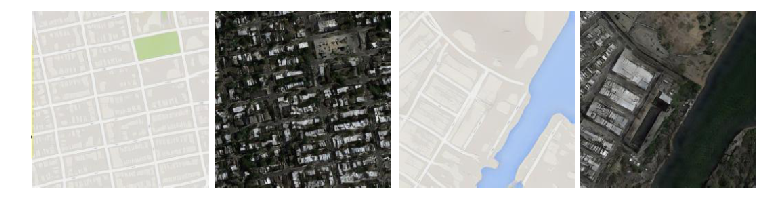

In [ ]:
plt.figure(figsize=(13,10))
plt.imshow(plt.imread('CycleGAN/imgs/terrain-generation.png'))
plt.axis('off')


## キャラクター/ヒーローの生成

私たちは、ポケモンの画像群と、別の8ビットの低解像度のヒーロー画像群で実験してみました。低解像度の画像群にエンコーダモデルを適用すると、高解像度のポケモン風画像が得られるのでは、と考えました。逆のに、ポケモンの画像群を8ビットレンダリング風に変換できるのでは、と考えました。もちろん、これらは深層学習を使わなくてもよい、十分シンプルなタスクです。そのため前者の方が、興味深いものです。面白いことに、変換により、色が完全に変わる傾向があります。色をより一定に保つため、効果的な損失関数の拡張があるかもしれません。これは論文中でも検討されています。


(-0.5, 1207.5, 643.5, -0.5)

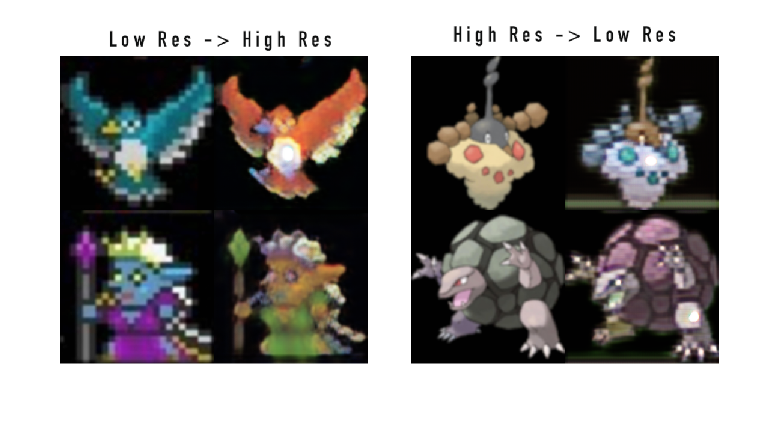

In [ ]:
plt.figure(figsize=(13,10))
plt.imshow(plt.imread('CycleGAN/imgs/character-generation.png'))
plt.axis('off')


## 他にもたくさんの例があります

 CycleGANの論文の著者は、彼らのGitHub上に、TorchとPytorchを使ったCycleGANの実装と共に、さらに多くのアイデアを提供しています:  [https://junyanz.github.io/CycleGAN/](https://junyanz.github.io/CycleGAN/)


# 結論

お役に立ったでしょうか。CycleGANで素晴らしいものを作れましたか？ [https://twitter.com/pkmital](https://twitter.com/pkmital)で私に共有してください。フィードバックをお聞きしたいです。 

また、Seq2Seq、DRAW、MDN、WaveNetなど、これらのネットワークや関連技術についてもっと知りたい場合は、 https://www.kadenze.com/programs/creative-applications-of-deep-learning-with-tensorflow をご覧ください。